# Helpfulness Prediction and Reviewer Archetypes

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import PoissonRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error

/opt/jupyterhub/venv/lib/python3.11/site-packages/joblib/_multiprocessing_helpers.py:44: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn("%s.  joblib will operate in serial mode" % (e,))


In [2]:
path = "steam_dataset/med_sample.parquet"

df = pd.read_parquet(path)

print(df.columns.tolist())

df

['recommendationid', 'appid', 'game', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access']


,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,140519529,1016120,PGA TOUR 2K21,76561199077333778,0,5,1479,14,1118,1698008669,...,1687469105,1687469105,1,0,0,0.000000,0,1,0,0
1,119776203,1030830,Mafia II: Definitive Edition,76561197988389071,0,2,749,0,749,1659206834,...,1659206951,1659206951,1,0,0,0.000000,0,1,0,0
2,70911195,105600,Terraria,76561198108034504,0,1,24148,0,13812,1691114801,...,1592356161,1592356161,1,0,0,0.000000,0,1,0,0
3,106448611,1012101,Train Simulator: Worcester - Mossel Bay Railwa...,76561198873228860,15,10,0,0,0,0,...,1640378437,1640378437,0,2,1,0.500000,0,1,0,0
4,90674964,105600,Terraria,76561198835398963,0,2,264,0,254,1619006558,...,1619004579,1619004579,1,0,0,0.000000,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000008,64802994,976730,Halo: The Master Chief Collection,76561198070601339,200,7,4995,0,1124,1678565736,...,1583833568,1583833568,1,0,0,0.000000,0,1,0,0
2000009,114895341,972660,Spiritfarer®: Farewell Edition,76561197997784415,0,14,2336,0,2172,1651856794,...,1651599808,1651599808,1,0,0,0.000000,0,1,0,0
2000010,133433034,990080,Hogwarts Legacy,76561198254505774,0,4,2263,0,689,1690131334,...,1677179524,1677179524,1,1,0,0.523810,0,1,0,0
2000011,132964135,990080,Hogwarts Legacy,76561198015745796,737,121,3514,0,1214,1678017430,...,1676550273,1676550273,1,1,0,0.525862,0,1,0,0


## Prepare Dataset for Helpfulness Prediction
In this section, we construct a supervised learning dataset to predict the **helpfulness votes (`votes_up`)** for each review.
- Define `votes_up` as the target variable (future helpfulness count).
- Filter out rows with missing review text or missing target values.
- Clip extreme outliers in `votes_up` to reduce the impact of the long-tailed distribution.
- Select and organize three groups of features:
  - **Text feature**: `review` (free-form review text).
  - **Numeric features**: game ownership, review counts, playtime, comment count, `votes_funny`, and `weighted_vote_score`.
  - **Categorical features**: language, `steam_purchase`, `received_for_free`, and `written_during_early_access`.
- Split the data into train and test sets. For now, we use a random split on the small sample; later on the full dataset we will use a time-based split to avoid label leakage.

In [3]:
target_col = "votes_up"

# Drop rows without review text or target label
df_model = df.dropna(subset=["review", target_col]).copy()

# Clip extreme outliers in votes_up to reduce long-tail impact
df_model[target_col] = df_model[target_col].clip(upper=df_model[target_col].quantile(0.99))

print("Samples after cleaning:", len(df_model))

text_col = "review"

numeric_features = [
    "author_num_games_owned",
    "author_num_reviews",
    "author_playtime_forever",
    "author_playtime_last_two_weeks",
    "author_playtime_at_review",
    "comment_count",
    "votes_funny",
    "weighted_vote_score"
]

categorical_features = [
    "language",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access"
]

# Fill missing values
df_model[numeric_features] = df_model[numeric_features].fillna(0)
df_model[categorical_features] = df_model[categorical_features].fillna("unknown")

X = df_model[[text_col] + numeric_features + categorical_features]
y = df_model[target_col].values

# Train-test split (random for small sample; you will use time-based split later)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Samples after cleaning: 1999967
Train size: (1599973, 13)
Test size: (399994, 13)


## Model for Helpfulness (Poisson Regression)
This section builds and evaluates a first-pass model for predicting **helpfulness votes (`votes_up`)** using both review text and user behavior features.

We follow a modular pipeline design:
1. **Preprocessing / Feature Engineering**
   - Apply **TF-IDF** to the `review` text (with unigrams + bigrams) to capture lexical and phrase-level patterns.
   - Standardize numeric behavioral features (e.g. number of games owned, total playtime, comment counts).
   - One-hot encode categorical features such as language and purchase flags.
   - Combine all feature types using a `ColumnTransformer`.
2. **Modeling**
   - Use a **Poisson regression model** (`PoissonRegressor`) as a simple and interpretable baseline for count data.
3. **Evaluation**
   - Evaluate the model on a held-out test set using:
     - **MSE** and **RMSE** (error magnitude in votes),
     - **MAE** (average absolute error),
     - **Spearman rank correlation (ρ)** to capture ranking quality, which is particularly important for prioritizing reviews.
   - Inspect a small table of true vs. predicted `votes_up` values to get an intuitive sense of model behavior.

In [4]:
# Preprocessing

# TF-IDF vectorizer for review text
text_transformer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2
)

# Numeric features: median imputation + scaling
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical features: mode imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine text, numeric, and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Poisson regression model (for count targets)
poisson_reg = PoissonRegressor(
    alpha=1e-4,
    max_iter=3000  # increased to help convergence
)

# Full pipeline: preprocessing + regression model
model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", poisson_reg)
])

# Train model
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:
# Evaluate

# Predict on test set
y_pred = model.predict(X_test)

# Clip negative predictions to zero (counts cannot be negative)
y_pred = np.clip(y_pred, 0, None)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"Spearman ρ: {spearman_corr:.4f}")

# Show first 10 predictions vs ground truth
comparison_df = pd.DataFrame({
    "votes_up_true": y_test[:10],
    "votes_up_pred": y_pred[:10]
})
comparison_df

MSE : 10.1635
RMSE: 3.1880
MAE : 1.0055
Spearman ρ: 0.7164


,votes_up_true,votes_up_pred
0,1,1.043102
1,0,0.048821
2,0,1.589037
3,0,0.021746
4,1,0.048441
5,0,0.027768
6,1,1.428439
7,8,4.278733
8,0,0.029871
9,0,0.041379


## Evaluation of Helpfulness Prediction Model
In this section, we add visuals to better understand model performance.

1. **Distribution of true vs predicted helpfulness values**  
   - Shows whether the model systematically underestimates or overestimates certain ranges.
2. **Scatter plot of predictions vs true values**  
   - Indicates how well the model fits the diagonal (perfect prediction line).  
   - In count data with many zeros, this is especially important.
3. **Residual plot (y_true - y_pred)**  
   - Visualizes model bias and variance.
4. **Calibration plot (optional but aligned with proposal)**  
   - Helps verify whether predicted counts match empirical averages.

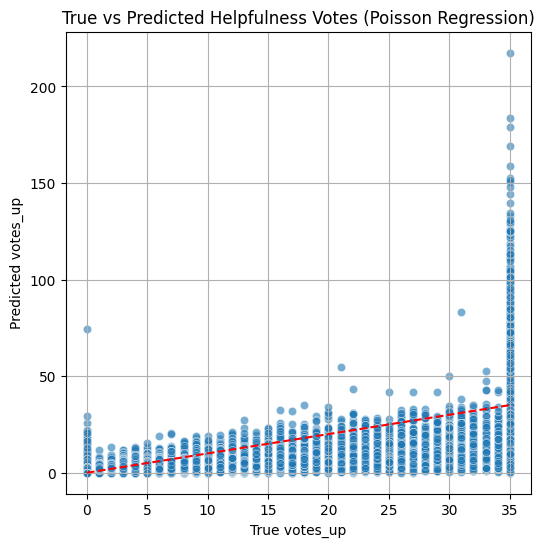

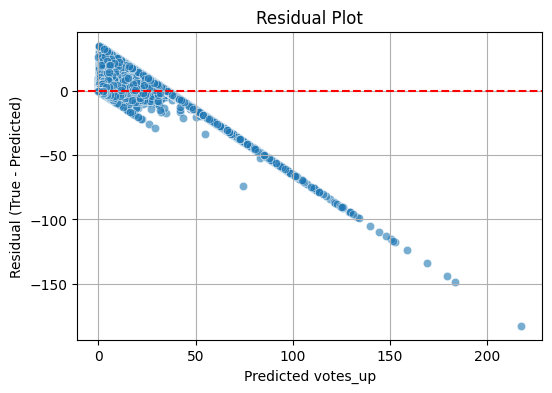

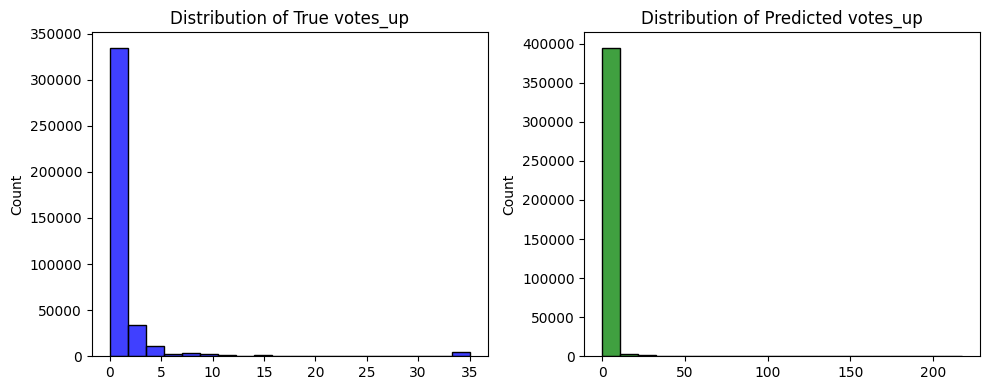

/tmp/ipykernel_3298072/2755520307.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_cal.groupby("bin").agg(


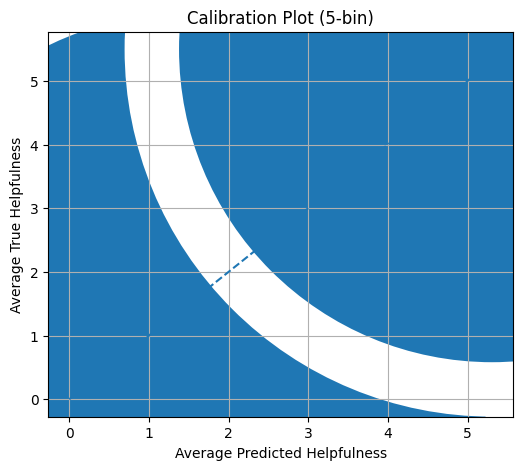

,avg_pred,avg_true,count
bin,,,
"(0.0026, 0.0395]",0.030961,0.037113,79999
"(0.0395, 0.049]",0.044754,0.055288,79999
"(0.049, 0.0726]",0.057544,0.110890,79998
"(0.0726, 2.387]",1.462741,1.139777,79999
"(2.387, 217.452]",5.307578,5.496819,79999


In [6]:
y_true = y_test
y_hat = y_pred

# Scatter Plot: true vs predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_hat, alpha=0.6)
plt.plot([0, max(y_true)], [0, max(y_true)], color='red', linestyle='--')
plt.xlabel("True votes_up")
plt.ylabel("Predicted votes_up")
plt.title("True vs Predicted Helpfulness Votes (Poisson Regression)")
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_true - y_hat

plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_hat, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted votes_up")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Distribution Comparison
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(y_true, bins=20, kde=False, color='blue')
plt.title("Distribution of True votes_up")

plt.subplot(1, 2, 2)
sns.histplot(y_hat, bins=20, kde=False, color='green')
plt.title("Distribution of Predicted votes_up")

plt.tight_layout()
plt.show()

# Simple Calibration Binning
df_cal = pd.DataFrame({"y_true": y_true, "y_pred": y_hat})
df_cal["bin"] = pd.qcut(df_cal["y_pred"], q=5, duplicates='drop')

calibration = df_cal.groupby("bin").agg(
    avg_pred=("y_pred", "mean"),
    avg_true=("y_true", "mean"),
    count=("y_true", "count")
)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=calibration["avg_pred"], y=calibration["avg_true"], s=calibration["count"]*3)
plt.plot([0, calibration["avg_pred"].max()], [0, calibration["avg_pred"].max()], linestyle='--')
plt.xlabel("Average Predicted Helpfulness")
plt.ylabel("Average True Helpfulness")
plt.title("Calibration Plot (5-bin)")
plt.grid(True)
plt.show()

calibration

## Reviewer-Level Features
The goal of this section is to move from **review-level data** to **reviewer-level profiles**, which we will use for unsupervised clustering.

Steps:
- Group reviews by `author_steamid` (unique reviewer ID).
- Aggregate multiple review-level statistics into reviewer-level features, including:
  - `num_reviews`: maximum number of reviews authored.
  - `games_owned`: maximum number of games owned.
  - `playtime_mean` and `playtime_recent_mean`: average total and recent playtime across reviews.
  - `votes_up_mean` and `votes_funny_mean`: average helpful and funny votes per review.
  - `voted_up_ratio`: fraction of reviews where the reviewer recommended the game.
  - `purchase_ratio`, `free_ratio`, `ea_ratio`: proportions of reviews coming from purchases, free keys, and early access periods.

In [7]:
cols_for_user_agg = [
    "author_steamid",
    "author_num_games_owned",
    "author_num_reviews",
    "author_playtime_forever",
    "author_playtime_last_two_weeks",
    "author_playtime_at_review",
    "voted_up",
    "votes_up",
    "votes_funny",
    "steam_purchase",
    "received_for_free",
    "written_during_early_access"
]

df_users = df[cols_for_user_agg].dropna(subset=["author_steamid"]).copy()

# Convert booleans to integers if necessary
bool_cols = ["steam_purchase", "received_for_free", "written_during_early_access"]
for c in bool_cols:
    df_users[c] = df_users[c].astype(int)

# Aggregate by reviewer
user_agg = df_users.groupby("author_steamid").agg(
    num_reviews=("author_num_reviews", "max"),
    games_owned=("author_num_games_owned", "max"),
    playtime_mean=("author_playtime_forever", "mean"),
    playtime_recent_mean=("author_playtime_last_two_weeks", "mean"),
    votes_up_mean=("votes_up", "mean"),
    votes_funny_mean=("votes_funny", "mean"),
    voted_up_ratio=("voted_up", "mean"),
    purchase_ratio=("steam_purchase", "mean"),
    free_ratio=("received_for_free", "mean"),
    ea_ratio=("written_during_early_access", "mean")
).reset_index()

print("Users aggregated:", user_agg.shape)
user_agg.head()

Users aggregated: (1625523, 11)


,author_steamid,num_reviews,games_owned,playtime_mean,playtime_recent_mean,votes_up_mean,votes_funny_mean,voted_up_ratio,purchase_ratio,free_ratio,ea_ratio
0,76561197960265841,12,325,755.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,76561197960265858,5,0,46.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,76561197960265890,10,0,18.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0
3,76561197960266146,3,0,5871.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,76561197960266531,1,774,4385.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Cluster Reviewers into Archetypes and Visualize (MiniBatchKMeans + PCA)
With the reviewer-level features we can now find **reviewer archetypes** using unsupervised clustering.

1. Select key behavioral features from `user_agg`.
2. Standardize all features with `StandardScaler` so that variables on different scales (e.g., playtime vs. ratios) contribute more evenly.
3. Run **MiniBatchKMeans** with a small number of clusters (e.g., `k = 5`) to obtain reviewer segments.
4. Generate:
   - Cluster sizes (how many users per archetype),
   - Cluster-level feature means (`cluster_profile`) for interpretation,
   - A 2D scatter plot using PCA to approximate the embedding.

In [8]:
# Select features and scale
feature_cols_user = [
    "num_reviews",
    "games_owned",
    "playtime_mean",
    "playtime_recent_mean",
    "votes_up_mean",
    "votes_funny_mean",
    "voted_up_ratio",
    "purchase_ratio",
    "free_ratio",
    "ea_ratio"
]

X_user = user_agg[feature_cols_user].fillna(0)

scaler_user = StandardScaler()
X_user_scaled = scaler_user.fit_transform(X_user)

# MiniBatchKMeans clustering
n_clusters = 5
kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=256
)
user_agg["cluster"] = kmeans.fit_predict(X_user_scaled)

# Cluster sizes
print("Cluster sizes:")
print(user_agg["cluster"].value_counts().sort_index())

# Cluster-level feature means (for persona interpretation)
cluster_profile = user_agg.groupby("cluster")[feature_cols_user].mean()
cluster_profile

Cluster sizes:
cluster
0    910219
1     63172
2    418583
3     34449
4    199100
Name: count, dtype: int64


,num_reviews,games_owned,playtime_mean,playtime_recent_mean,votes_up_mean,votes_funny_mean,voted_up_ratio,purchase_ratio,free_ratio,ea_ratio
cluster,,,,,,,,,,
0,11.132173,84.893585,11003.976767,40.639095,1.529881,73925.435309,0.988450,0.987816,0.000670,0.132258
1,12.610112,123.750158,14365.438550,69.885307,1.851665,0.634489,0.893509,0.328987,0.921816,0.104815
2,11.348294,112.142767,13171.319364,38.759256,1.528757,10261.332434,0.990309,0.050382,0.001339,0.093055
3,4.849662,64.930390,231304.352757,2264.564786,3.030434,124677.190425,0.904066,0.594232,0.017052,0.071868
4,15.180663,127.478031,10003.715495,35.698817,6.974211,149207.277240,0.051245,0.621339,0.001757,0.127083


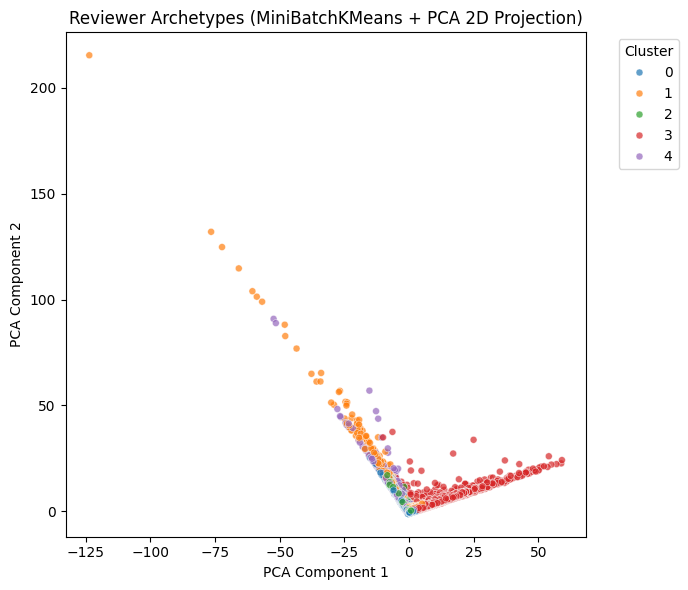

In [9]:
# PCA 2D projection for visualization
pca = PCA(n_components=2, random_state=42)
X_user_pca = pca.fit_transform(X_user_scaled)

user_agg["pca_1"] = X_user_pca[:, 0]
user_agg["pca_2"] = X_user_pca[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=user_agg,
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="tab10",
    alpha=0.7,
    s=25
)
plt.title("Reviewer Archetypes (MiniBatchKMeans + PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

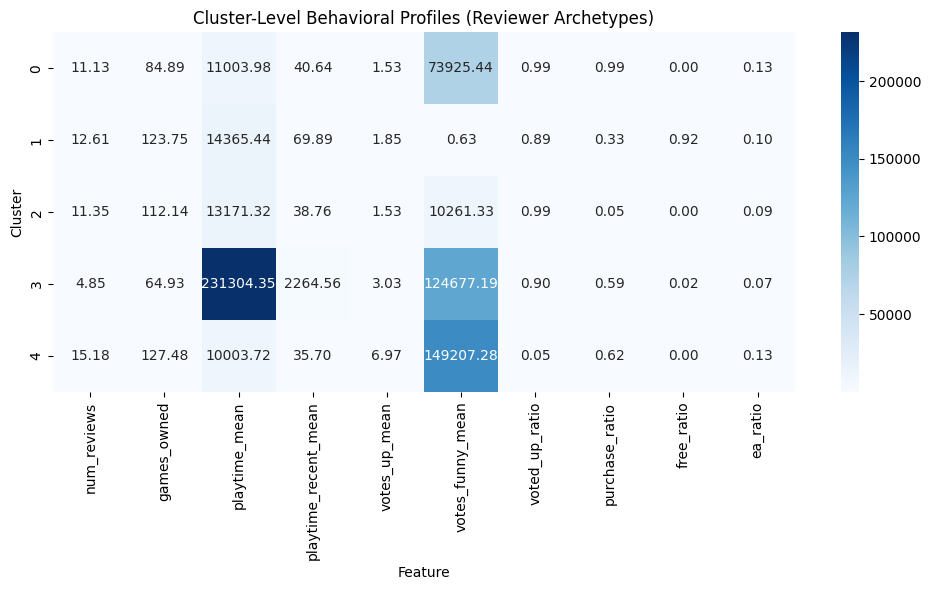

In [10]:
# Heatmap of cluster centers (behavioral profile per archetype)

plt.figure(figsize=(10, 6))
sns.heatmap(
    cluster_profile,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)
plt.title("Cluster-Level Behavioral Profiles (Reviewer Archetypes)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

## Generate Reviewer Personas
Now that we have clusters, the next step is to interpret each cluster and generate personas.

1. Compute additional summary statistics per cluster (e.g., average helpfulness).
2. Generate persona descriptions using heuristics based on:
   - game ownership
   - review volume
   - playtime levels
   - purchase vs free-key behavior
   - helpfulness & funny vote patterns

In [11]:
# Compute summary per cluster
cluster_stats = user_agg.groupby("cluster").agg(
    reviewers=("author_steamid", "count"),
    avg_reviews=("num_reviews", "mean"),
    avg_games_owned=("games_owned", "mean"),
    avg_playtime=("playtime_mean", "mean"),
    avg_recent_play=("playtime_recent_mean", "mean"),
    avg_votes_up=("votes_up_mean", "mean"),
    avg_votes_funny=("votes_funny_mean", "mean"),
    voted_up_ratio=("voted_up_ratio", "mean"),
    purchase_ratio=("purchase_ratio", "mean"),
    free_ratio=("free_ratio", "mean"),
    ea_ratio=("ea_ratio", "mean")
).round(3)

cluster_stats

,reviewers,avg_reviews,avg_games_owned,avg_playtime,avg_recent_play,avg_votes_up,avg_votes_funny,voted_up_ratio,purchase_ratio,free_ratio,ea_ratio
cluster,,,,,,,,,,,
0,910219,11.132,84.894,11003.977,40.639,1.530,73925.435,0.988,0.988,0.001,0.132
1,63172,12.610,123.750,14365.439,69.885,1.852,0.634,0.894,0.329,0.922,0.105
2,418583,11.348,112.143,13171.319,38.759,1.529,10261.332,0.990,0.050,0.001,0.093
3,34449,4.850,64.930,231304.353,2264.565,3.030,124677.190,0.904,0.594,0.017,0.072
4,199100,15.181,127.478,10003.715,35.699,6.974,149207.277,0.051,0.621,0.002,0.127


In [12]:
def describe_cluster(row):
    desc = []

    # Game ownership (Cluster 4 is highest at 127.48, Cluster 3 is lowest at 64.93)
    if row["avg_games_owned"] > 125:
        desc.append("owns a very large game library (veteran player)")
    elif row["avg_games_owned"] > 80:
        desc.append("owns a moderately large number of games")
    else: # Catches Cluster 3 (64.93)
        desc.append("owns a relatively small game library")

    # Review count (Cluster 4 is highest at 15.18, Cluster 3 is lowest at 4.85)
    if row["avg_reviews"] > 14:
        desc.append("is a highly active reviewer")
    elif row["avg_reviews"] > 10:
        desc.append("writes reviews regularly")
    else: # Catches Cluster 3 (4.85)
        desc.append("rarely writes reviews")

    # Playtime (Cluster 3 is an extreme outlier at 231304.35)
    if row["avg_playtime"] > 100000:
        desc.append("has EXTREME deep long-term playtime (Core Player)")
    elif row["avg_playtime"] > 10000:
        desc.append("has deep long-term playtime across games")
    else: # This category might be empty based on current data, but covers low engagement
        desc.append("shows moderate long-term playtime")

    # Purchase behavior (Cluster 1 is free-key heavy at 0.92 free_ratio)
    if row["free_ratio"] > 0.8: # Catches Cluster 1
        desc.append("FITS THE FREE-KEY HEAVY ARCHETYPE")
    elif row["purchase_ratio"] > 0.9: # Catches Cluster 0 and 2
        desc.append("mostly reviews games they purchased")
    else: # Catches Cluster 3 and 4 (mixed or moderate ratios)
        desc.append("has mixed purchase/free behavior")

    # Positivity (Cluster 4 is the negative outlier at 0.05 voted_up_ratio, others are high ~0.9+)
    if row["voted_up_ratio"] < 0.4: # Catches Cluster 4
        desc.append("tends to leave critical/negative reviews")
    elif row["voted_up_ratio"] > 0.85:
        desc.append("tends to write very positive reviews")
    else:
        desc.append("has balanced positivity")

    # Helpfulness (Cluster 4 is highly influential at 6.97, Cluster 3 is moderate at 3.03)
    if row["avg_votes_up"] > 5: # Catches Cluster 4
        desc.append("is a HIGHLY INFLUENTIAL reviewer (Highest helpfulness)")
    elif row["avg_votes_up"] > 2.5: # Catches Cluster 3
        desc.append("receives moderately high helpfulness on their reviews")
    else:
        desc.append("typically receives low helpfulness")

    return "; ".join(desc)

persona_cards = cluster_stats.apply(describe_cluster, axis=1)

In [13]:
pd.set_option("display.max_colwidth", None)
persona_table = pd.DataFrame({
    "Cluster": persona_cards.index,
    "Persona Description": persona_cards.values
})

persona_table

,Cluster,Persona Description
0,0,owns a moderately large number of games; writes reviews regularly; has deep long-term playtime across games; mostly reviews games they purchased; tends to write very positive reviews; typically receives low helpfulness
1,1,owns a moderately large number of games; writes reviews regularly; has deep long-term playtime across games; FITS THE FREE-KEY HEAVY ARCHETYPE; tends to write very positive reviews; typically receives low helpfulness
2,2,owns a moderately large number of games; writes reviews regularly; has deep long-term playtime across games; has mixed purchase/free behavior; tends to write very positive reviews; typically receives low helpfulness
3,3,owns a relatively small game library; rarely writes reviews; has EXTREME deep long-term playtime (Core Player); has mixed purchase/free behavior; tends to write very positive reviews; receives moderately high helpfulness on their reviews
4,4,owns a very large game library (veteran player); is a highly active reviewer; has deep long-term playtime across games; has mixed purchase/free behavior; tends to leave critical/negative reviews; is a HIGHLY INFLUENTIAL reviewer (Highest helpfulness)
